In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# In order to access parent directory..
import sys
sys.path.append('../')
from models.spatial_tfm_nw import Stnet

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
mnist_train = datasets.MNIST('../datasets/from_pytorch', True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((.1307,), (.3081,))
                             ]))

mnist_test  = datasets.MNIST('../datasets/from_pytorch', False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((.1307,), (.3081,))
                            ]))

In [51]:
train_dl = DataLoader(mnist_train, 64, True)
test_dl  = DataLoader(mnist_test , 64, True)

In [64]:
model = Stnet().to(device)
opt = optim.SGD(model.parameters(), .01)

In [53]:
def train(e):
    model.train()
    for i, (xb, yb) in enumerate(train_dl):
        xb, yb = xb.to(device), yb.to(device)
        loss = F.cross_entropy(model(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i%500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(e, i*len(xb), len(train_dl.dataset),
                          100. * i / len(train_dl), loss.item()))

In [54]:
def accuracy(out, yb): return (torch.argmax(out, -1)==yb).float().mean()

In [55]:
def test():
    with torch.no_grad():
        model.eval()
        tot_loss, tot_acc = 0, 0
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            tot_loss += F.cross_entropy(out, yb)
            tot_acc  += accuracy(out, yb)
        nv = len(test_dl)
        print('¥n Testset: Avg loss: {:.4f}, Acc: {:.4f}'
              .format(tot_loss/nv, tot_acc/nv))

In [56]:
def convert_img_np(x):
    """Convert tensort to np img"""
    x = x.numpy().transpose((1,2,0))
    mean = np.array([.485, .456, .406])
    std  = np.array([.229, .224, .225])
    x = x*std + mean
    x = np.clip(x, 0, 1)
    return x

In [57]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_dl))[0].to(device)
        
        inp_tensor = data.cpu()
        tfm_inp_tensor = model.stn(data).cpu()
        
        in_grid  = convert_img_np(torchvision.utils.make_grid(inp_tensor))
        out_grid = convert_img_np(torchvision.utils.make_grid(tfm_inp_tensor))
        
        f, ax = plt.subplots(1, 2)
        ax[0].imshow(in_grid)
        ax[0].set_title('Dataset Imgs')
        ax[1].imshow(out_grid)
        ax[1].set_title('Tfms Imgs')

In [150]:
for e in range(1, 30+1):
    train(e)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.276840
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.128352
¥n Testset: Avg loss: 0.0622, Acc: 0.9814
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.098748
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.258600
¥n Testset: Avg loss: 0.0636, Acc: 0.9801
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.140728
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.203709
¥n Testset: Avg loss: 0.0501, Acc: 0.9837
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.081710
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.096452
¥n Testset: Avg loss: 0.0602, Acc: 0.9823
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.126776
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.139717
¥n Testset: Avg loss: 0.0474, Acc: 0.9850
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.098812
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.087636
¥n Testset: Avg loss: 0.0458, Acc: 0.9863
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.155646
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.095027
¥n Testset: Avg loss: 0.0491, Acc: 0.9859
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.081

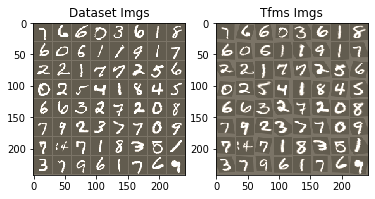

In [149]:
# 5 epochs
visualize_stn()

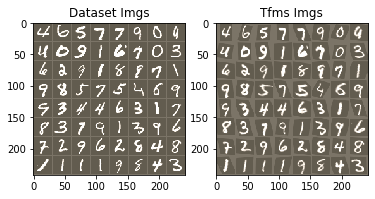

In [151]:
# 30 epochs
visualize_stn()

In [153]:
torch.save(model.state_dict(), 'stn_30epoch.pt')